### trying out functions 

In [5]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from Utils_python import llh2localxy
from Utils_python import remove_polygon
from Utils_python import quadtree_regular
from Utils_python import quadtree_irregular

In [ ]:
def fit_bilinplane(data, coord):
    # Clean data and coordinates of NaNs, update coordinate vector accordingly:
    no_nan_ind = np.where(~np.isnan(data))[0]
    d = data[no_nan_ind]
    coord = coord[:, no_nan_ind]

    # Get the number of data points
    N = len(d)

    # If 3 or more data points are left after NaN screening, then
    if N >= 3:
        # Make matrix G
        ones = np.ones(N)
        G = np.vstack((ones, coord[0, :], coord[1, :])).T
        gtginv = inv(np.dot(G.T, G))

        m = np.dot(gtginv, np.dot(G.T, d))

        # Calculate the rms
        rootms = np.sqrt(np.mean((d - np.dot(G, m))**2))
    else:
        rootms = 0
        G = 0
        m = np.array([0, 0, 0])

    return m, G, rootms






In [ ]:
### Following are how to run the different function 

In [5]:
# Sample latitude, longitude in decimal degrees
# Each column represents a data point
llh = np.array([[34.05, 34.10, 34.15],  # Latitude values
                [-118.24, -118.20, -118.10]])  # Longitude values

# Latitude of origin in decimal degrees
ll_org = np.array([34.10, -118.20])

# Call the llh2localxy function
xy = llh2localxy(llh, ll_org)

# Print the result
print("Local XY Coordinates (in km):")
print(xy)

Local XY Coordinates (in km):
[[-3.70344969 -5.54602705]
 [-0.          0.        ]
 [ 9.24777988  5.54607278]]


In [6]:
import matplotlib
matplotlib.use('TkAgg')

# Create a sample array (replace this with your actual data)
array = np.random.rand(100, 100)

# Define the bounding box for the polygon (xmin, xmax, ymin, ymax)
xmin = 20
xmax = 80
ymin = 30
ymax = 70

# Call the function to remove the polygon from the array
#remove_polygon.remove_polygon_from_array(array, xmin, xmax, ymin, ymax)

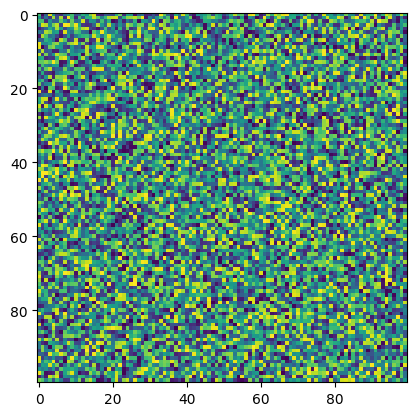

In [7]:
%matplotlib inline

plt.imshow(array)

In [8]:

# Define your input data, tolerance, and fittype
data = array  # Replace with your data
tolerance = 0.1  # Set your tolerance value
fittype = 1  # Set your fittype (1 for median, 2 for bilinear plane)

# Call the quadtree_part function
indmat, sqval, cx, cy, cntp, nlin = quadtree_regular.quadtree_part(data, tolerance, fittype)



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 2